In [5]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

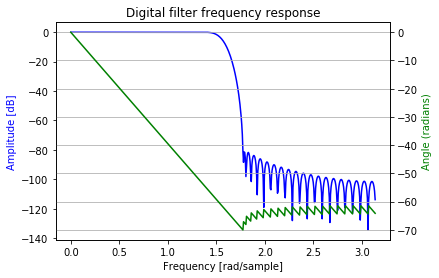

In [1]:
import numpy as np
from scipy import signal
b = signal.firwin(80, 0.5, window=('kaiser', 8))
w, h = signal.freqz(b)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()


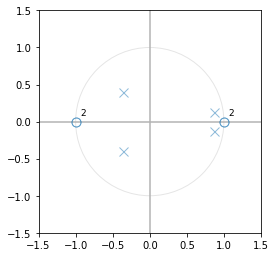

4 zeros: [-1.00000000 +1.11412166e-08j -1.00000000 -1.11412166e-08j
  1.00000001 +0.00000000e+00j  0.99999999 +0.00000000e+00j]
4 poles: [ 0.86702694+0.12873979j  0.86702694-0.12873979j -0.35839171+0.39679705j
 -0.35839171-0.39679705j]
gain: 0.434739348285


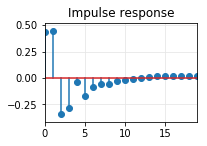

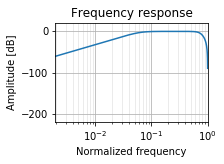

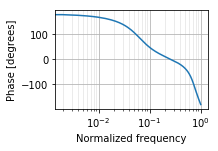

In [9]:
# -*- coding: utf-8 -*-
"""
Combination of 
http://scipy-central.org/item/52/1/zplane-function
and
http://www.dsprelated.com/showcode/244.php
with my own modifications
"""

# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.


# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict
    

def zplane(z, p, filename=None):
    """Plot the complex z-plane given zeros and poles.
    """
    
    # get a figure/plot
    ax = plt.subplot(2, 2, 1)
    # TODO: should just inherit whatever subplot it's called in?

    # Add unit circle and zero axes    
    unit_circle = patches.Circle((0,0), radius=1, fill=False,
                                 color='black', ls='solid', alpha=0.1)
    ax.add_patch(unit_circle)
    axvline(0, color='0.7')
    axhline(0, color='0.7')
    
    # Plot the poles and set marker properties
    poles = plt.plot(p.real, p.imag, 'x', markersize=9, alpha=0.5)
    
    # Plot the zeros and set marker properties
    zeros = plt.plot(z.real, z.imag,  'o', markersize=9, 
             color='none', alpha=0.5,
             markeredgecolor=poles[0].get_color(), # same color as poles
             )

    # Scale axes to fit
    r = 1.5 * np.amax(np.concatenate((abs(z), abs(p), [1])))
    plt.axis('scaled')
    plt.axis([-r, r, -r, r])
#    ticks = [-1, -.5, .5, 1]
#    plt.xticks(ticks)
#    plt.yticks(ticks)

    """
    If there are multiple poles or zeros at the same point, put a 
    superscript next to them.
    TODO: can this be made to self-update when zoomed?
    """
    # Finding duplicates by same pixel coordinates (hacky for now):
    poles_xy = ax.transData.transform(np.vstack(poles[0].get_data()).T)
    zeros_xy = ax.transData.transform(np.vstack(zeros[0].get_data()).T)    

    # dict keys should be ints for matching, but coords should be floats for 
    # keeping location of text accurate while zooming

    # TODO make less hacky, reduce duplication of code
    d = defaultdict(int)
    coords = defaultdict(tuple)
    for xy in poles_xy:
        key = tuple(np.rint(xy).astype('int'))
        d[key] += 1
        coords[key] = xy
    for key, value in d.items():
        if value > 1:
            x, y = ax.transData.inverted().transform(coords[key])
            plt.text(x, y, 
                        r' ${}^{' + str(value) + '}$',
                        fontsize=13,
                        )

    d = defaultdict(int)
    coords = defaultdict(tuple)
    for xy in zeros_xy:
        key = tuple(np.rint(xy).astype('int'))
        d[key] += 1
        coords[key] = xy
    for key, value in d.items():
        if value > 1:
            x, y = ax.transData.inverted().transform(coords[key])
            plt.text(x, y, 
                        r' ${}^{' + str(value) + '}$',
                        fontsize=13,
                        )

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
        print('Pole-zero plot saved to ' + str(filename))


if __name__ == "__main__":
    from scipy.signal import (freqz, butter, bessel, cheby1, cheby2, ellip, 
                              tf2zpk, zpk2tf, lfilter, buttap, bilinear, cheb2ord, cheb2ap
                              )
    from numpy import asarray, tan, array, pi, arange, cos, log10, unwrap, angle
    from matplotlib.pyplot import (stem, title, grid, show, plot, xlabel, 
                                  ylabel, subplot, xscale, figure, xlim, 
                                  margins)
    
#    # Cosine function
#    omega = pi/4
#    b = array([1.0, -cos(omega)])
#    a = array([1, -2*cos(omega), 1.0])
    
    b, a = butter(2, [0.06, 0.7], 'bandpass')

    # Get the poles and zeros
    z, p, k = tf2zpk(b, a)

    # Create zero-pole plot
    figure(figsize=(16, 9))
    subplot(2, 2, 1)
    zplane(z, p)
    grid(True, color='0.9', linestyle='-', which='both', axis='both')
    title('Poles and zeros')
    
    # Display zeros, poles and gain
    print(str(len(z)) + " zeros: " + str(z))
    print(str(len(p)) + " poles: " + str(p))
    print("gain: " + str(k))
    
    # Impulse response
    index = arange(0,20)
    u = 1.0*(index==0)
    y = lfilter(b, a, u)
    subplot(2, 2, 3)
    stem(index,y)
    title('Impulse response')
    margins(0, 0.1)
    grid(True, color='0.9', linestyle='-', which='both', axis='both')
    show()
    
    # Frequency response
    w, h = freqz(b, a)
    subplot(2, 2, 2)
    plot(w/pi, 20*log10(abs(h+1e-10)))
    xscale('log')

    title('Frequency response')
    xlabel('Normalized frequency')
    ylabel('Amplitude [dB]')
    margins(0, 0.1)
    grid(True, color = '0.7', linestyle='-', which='major', axis='both')
    grid(True, color = '0.9', linestyle='-', which='minor', axis='both')
    show()

    # Phase
    subplot(2, 2, 4)
    plot(w/pi, 180/pi * unwrap(angle(h)))
    xscale('log')
    xlabel('Normalized frequency')
    ylabel('Phase [degrees]')
    grid(True, color = '0.7', linestyle='-', which='major')
    grid(True, color = '0.9', linestyle='-', which='minor')
    show()